In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20, 20)
import matplotlib.image as mpimg
import cv2
import numpy as np
import collections
from calibration import calibration, undistort
from binarization import binarize
from birdeye import birdeye

In [2]:
class Line:
    def __init__(self, buffer_len=10):
        # flag to mark if the line was be detected the last iteration
        self.detected = False
        
        # polynomial coefficents fitted on the last iteration
        self.last_fit_pixel = None
        self.last_fit_meter = None
        
        # list of polynomial coefficients of the last N iterations
        self.recent_fits_pixel = collections.deque(maxlen=buffer_len)
        self.recent_fits_meter = collections.deque(maxlen=buffer_len * 2)
        
        self.radius_of_curvature = None
        
        # store all pixels coords (x, y) of line detected
        self.all_x = None
        self.all_y = None
    
    """
    Update line with new fitted coefficients.
    Args:
      new_fit_pixel: new polynomial coefficients (pixel)
      new_fit_meter: new polynomial coefficients (meter)
      detected: if the line was detected or inferred
      clear_buffer: if True, reset state
    """
    def update_line(self, new_fit_pixel, new_fit_meter, detected, clear_buffer=False):
        self.detected = detected
        
        if clear_buffer:
            self.recent_fits_pixel = []
            self.recent_fits_meter = []
        
        self.last_fit_pixel = new_fit_pixel
        self.last_fit_meter = new_fit_meter
        
        self.recent_fits_pixel.append(self.last_fit_pixel)
        self.recent_fits_meter.append(self.last_fit_meter)
    
    """
    Draw the line on a color mask image
    Args:
      mask: color mask image
      color: painting colour
      line_width: line width
      average:
    """
    def draw(self, mask, color=(255, 0, 0), line_width=50, average=False):
        h, w, c = mask.shape
        # variables
        plot_y = np.linspace(0, h-1, h)
        # coefficients
        coeffs = self.average_fit if average else self.last_fit_pixel
        # use above to draw a curve also a centre of lane
        line_center = coeffs[0] * plot_y**2 + coeffs[1] * plot_y + coeffs[2]
        # left
        line_left_side = line_center - line_width // 2
        # right
        line_right_side = line_center + line_width // 2
        
        # some magic here to recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array(list(zip(line_left_side, plot_y)))
        pts_right = np.array(np.flipud(list(zip(line_right_side, plot_y))))
        pts = np.vstack([pts_left, pts_right])
        
        # draw the lane onto the warped blank image
        # which pertaining to fill the blank part between left/right lane.
        return cv2.fillPoly(mask, [np.int32(pts)], color)
    
    """
    Average of polynomial coefficients of the last N iterations
    """
    @property
    def average_fit(self):
        return np.mean(self.recent_fits_pixel, axis=0)
    
    """
    Radius of curvature of the line (averaged)
    """
    @property
    def curvature(self):
        y_eval = 0
        coeffs = self.average_fit
        return ((1+(2*coeffs[0]*y_eval + coeffs[1])**2)**1.5) / np.absolute(2*coeffs[0])
    
    """
    Radius of curvature of the line (averaged)
    """
    @property
    def curvature_meter(self):
        y_eval = 0
        coeffs = np.mean(self.recent_fits_meter, axis=0)
        return ((1+ (2*coeffs[0]*y_eval + coeffs[1])**2)**1.5) / np.absolute(2*coeffs[0])


In [3]:
"""
update left or right line
Args:
  line_side: side of line is to be updated
Return:
  fitted pixel and meter in line
"""
def _update_left_or_right_line(line_side):
    # meters per pixel in y and x dimension
    ym_per_pix = 30 / 720
    xm_per_pix = 3.7 / 700
    
    detected = True
    if not list(line_side.all_x) or not list(line_side.all_y):
        line_side_fit_pixel = line_side.last_fit_pixel
        line_side_fit_meter = line_side.last_fit_meter
        detected = False
    else:
        line_side_fit_pixel = np.polyfit(line_side.all_y, line_side.all_x, 2)
        line_side_fit_meter = np.polyfit(line_side.all_y * ym_per_pix, line_side.all_x * xm_per_pix, 2)
    line_side.update_line(line_side_fit_pixel, line_side_fit_meter, detected=detected)
    
    return line_side_fit_pixel, line_side_fit_meter

In [4]:
"""
Using sliding window to get fitted polynomial coefficients.
Args:
  birdeye_binary: binary image in birdeye
  line_lt: left lane-line previously detected.
  line_rt: right lane-line previously detected.
  n_windows: nums of sliding windows
  verbose

Return:
  updated lane lines and output image.
"""
def get_fits_by_sliding_windows(birdeye_binary, line_lt, line_rt, n_windows=9, verbose=False):
    
    height, width = birdeye_binary.shape
    
    # get histogram from half to bottom-margin 30
    histogram = np.sum(birdeye_binary[height//2:-30, :], axis=0)
    
    # create output image to draw on and visualize it.
    out_img = np.dstack((birdeye_binary, birdeye_binary, birdeye_binary)) * 255
    
    # find the peak of left/right halves of the histogram
    # these will be the starting point for the left and right lines
    midpoint = len(histogram)//2
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # set height of window
    window_height = np.int(height / n_windows)
    
    # identify the x and y positions of all nonzero pixels in the image
    nonzero = birdeye_binary.nonzero()
    nonzero_y = np.array(nonzero[0])
    nonzero_x = np.array(nonzero[1])
    
    # current position to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    margin = 100
    minpix = 50
    
    # create empty lists to store left and right lane `pixel indices`
    left_lane_inds = []
    right_lane_inds = []
    
    # step through the windows one by one
    for window in range(n_windows):
        # identify window boundaries in x and y (and left/right)
        win_y_low = height - (window+1) * window_height
        win_y_high = height - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # draw the windows on the visualization image
        cv2.rectangle(out_img, (win_xleft_low, win_y_low),
                     (win_xleft_high, win_y_high), (0, 255, 0), 2)
        cv2.rectangle(out_img, (win_xright_low, win_y_low),
                     (win_xright_high, win_y_high), (0, 255, 0), 2)
        
        # identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzero_y >= win_y_low) & (nonzero_y < win_y_high)
                         & (nonzero_x >= win_xleft_low) & (nonzero_x < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzero_y >= win_y_low) & (nonzero_y < win_y_high)
                         & (nonzero_x >= win_xright_low) & (nonzero_x < win_xright_high)).nonzero()[0]
        
        # append to list
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # if found up > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzero_x[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzero_x[good_right_inds]))
    
    # concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # extract left and right line pixel positions
    line_lt.all_x, line_lt.all_y = nonzero_x[left_lane_inds], nonzero_y[left_lane_inds]
    line_rt.all_x, line_rt.all_y = nonzero_x[right_lane_inds], nonzero_y[right_lane_inds]
    
    # update pixel and meter in left line
    left_fit_pixel, _ = _update_left_or_right_line(line_lt)
    # update pixel and meter in right line
    right_fit_pixel, _ = _update_left_or_right_line(line_rt)
    
    # generate x and y values for plotting
    ploty = np.linspace(0, height -1, height)
    left_fitx = left_fit_pixel[0] * ploty**2 + left_fit_pixel[1] * ploty + left_fit_pixel[2]
    right_fitx = right_fit_pixel[0] * ploty**2 + right_fit_pixel[1] * ploty + right_fit_pixel[2]
    
    # draw left - red
    out_img[nonzero_y[left_lane_inds], nonzero_x[left_lane_inds]] = [255, 0, 0]
    # draw right - blue
    out_img[nonzero_y[right_lane_inds], nonzero_x[right_lane_inds]] = [0, 0, 255]
    
    if verbose:
        f, ax = plt.subplots(1, 2)
        f.set_facecolor('white')
        ax[0].imshow(birdeye_binary, cmap='gray')
        ax[1].imshow(out_img)
        ax[1].plot(left_fitx, ploty, color='yellow')
        ax[1].plot(right_fitx, ploty, color='yellow')
        ax[1].set_xlim(0, 1280)
        ax[1].set_ylim(720, 0)
        
        plt.show()
    
    return line_lt, line_rt, out_img

In [5]:
"""
Based on previous line data to fit current line.
Args:
  birdeye_binary: binary image in birdeye
  line_lt: left side of line
  line_rt: right side of line
Return:
  updated lane lines and output image
"""
def get_fits_by_previous_fits(birdeye_binary, line_lt, line_rt, verbose=False):
    height, width = birdeye_binary.shape
    
    left_fit_pixel = line_lt.last_fit_pixel
    right_fit_pixel = line_rt.last_fit_pixel
    
    nonzero = birdeye_binary.nonzero()
    nonzero_y = np.array(nonzero[0])
    nonzero_x = np.array(nonzero[1])
    
    margin = 100
    
    def _find_best_position_indices(fit_pixel):
        poly_threshold = fit_pixel[0] * (nonzero_y**2) + fit_pixel[1] * nonzero_y + fit_pixel[2]
        lane_inds = (nonzero_x > poly_threshold - margin) & (nonzero_x < poly_threshold + margin)
        return lane_inds
    
    # left lane indices
    left_lane_inds = _find_best_position_indices(left_fit_pixel)
    # right lane indices
    right_lane_inds = _find_best_position_indices(right_fit_pixel)
    
    # extract left and right line pixel positions
    line_lt.all_x, line_lt.all_y = nonzero_x[left_lane_inds], nonzero_y[left_lane_inds]
    line_rt.all_x, line_rt.all_y = nonzero_x[right_lane_inds], nonzero_y[right_lane_inds]
    
    # update left line
    left_fit_pixel, _ = _update_left_or_right_line(line_lt)
    # update right line
    right_fit_pixel, _ = _update_left_or_right_line(line_rt)
    
    # generate x and y values for plotting
    ploty = np.linspace(0, height-1, height)
    left_fitx = left_fit_pixel[0]*ploty**2 + left_fit_pixel[1]*ploty + left_fit_pixel[2]
    right_fitx = right_fit_pixel[0]*ploty**2 + right_fit_pixel[1]*ploty + right_fit_pixel[2]
    
    # create an image to draw on and an image to show the selection window
    img_fit = np.dstack((birdeye_binary, birdeye_binary, birdeye_binary)) * 255
    window_img = np.zeros_like(img_fit)
    
    # color in left and right line pixels
    img_fit[nonzero_y[left_lane_inds], nonzero_x[left_lane_inds]] = [255, 0, 0]
    img_fit[nonzero_y[right_lane_inds], nonzero_x[right_lane_inds]] = [0, 0, 255]
    
    # generate a polygon to illustrate the search window area
    # and recast the x and y points into usable format for cv2.fillPoly()
    def _generate_points_for_window_plotting(fitx):
        line_window1 = np.array([np.transpose(np.vstack([fitx - margin, ploty]))])

        line_window2 = np.array([np.flipud(np.transpose(np.vstack([fitx + margin, ploty])))])

        line_pts = np.hstack((line_window1, line_window2))
        
        return line_pts
    
    left_line_pts = _generate_points_for_window_plotting(left_fitx)
    right_line_pts = _generate_points_for_window_plotting(right_fitx)
    
    # draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0, 255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0, 255, 0))
    result = cv2.addWeighted(img_fit, 1, window_img, 0.3, 0)
    
    if verbose:
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        
        plt.show()
    
    return line_lt, line_rt, img_fit

In [6]:
"""
draw both the drivable lane area and the detected lane-lines onto the original frame.
Args:
  img_undistorted: original undistorted color frame
  Minv: (inverse) perspective transform matrix used to re-project on original frame
  line_lt: left lane-line
  line_rt: right lane-line
  keep_state: if True, line state is maintained
Return:
  blending image
"""
def draw_back_onto_the_road(img_undistorted, Minv, line_lt, line_rt, keep_state):
    height, width = img_undistorted.shape[:2]
    
    left_fit = line_lt.average_fit if keep_state else line_lt.last_fit_pixel
    right_fit = line_rt.average_fit if keep_state else line_rt.last_fit_pixel
    
    # generate x and y values for plotting
    ploty = np.linspace(0, height-1, height)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # draw road as green polygon on original frame
    road_warp = np.zeros_like(img_undistorted, dtype=np.uint8)
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    cv2.fillPoly(road_warp, np.int_([pts]), (0, 255, 0))
    # warp back to original image space
    road_dewarped = cv2.warpPerspective(road_warp, Minv, (width, height))
    blend_onto_road = cv2.addWeighted(img_undistorted, 1., road_dewarped, 0.3, 0)
    
    # now seperately draw solid lines to highlight them
    line_warp = np.zeros_like(img_undistorted)
    line_warp = line_lt.draw(line_warp, color=(255, 0, 0), average=keep_state)
    line_warp = line_rt.draw(line_warp, color=(0, 0, 255), average=keep_state)
    line_dewarped = cv2.warpPerspective(line_warp, Minv, (width, height))
    
    lines_mask = blend_onto_road.copy()
    idx = np.any([line_dewarped != 0][0], axis=2)
    lines_mask[idx] = line_dewarped[idx]
    
    blend_onto_road = cv2.addWeighted(src1=lines_mask, alpha=0.8, src2=blend_onto_road, beta=0.5, gamma=0.)
    
    return blend_onto_road

/home/jameschien/anaconda2/lib/python2.7/site-packages/numpy/lib/polynomial.py:584: RuntimeWarning: invalid value encountered in true_divide
  lhs /= scale
/home/jameschien/anaconda2/lib/python2.7/site-packages/numpy/lib/polynomial.py:586: RuntimeWarning: divide by zero encountered in true_divide
  c = (c.T/scale).T  # broadcast scale coefficients
/home/jameschien/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:20: RankWarning: Polyfit may be poorly conditioned
/home/jameschien/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:20: RankWarning: Polyfit may be poorly conditioned


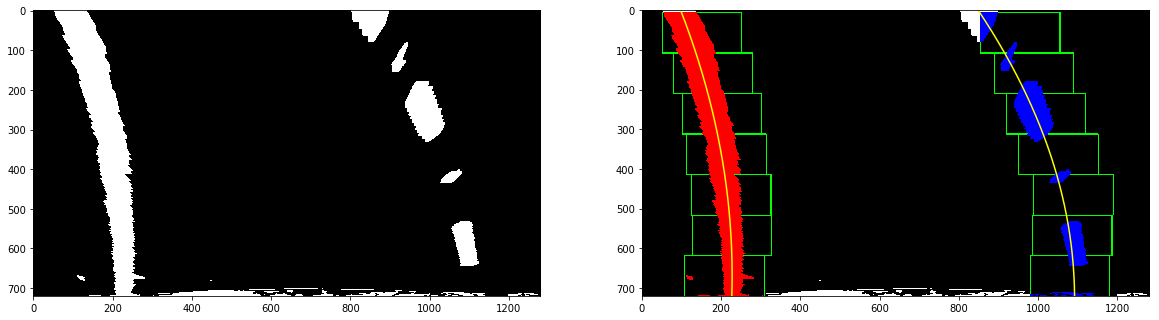

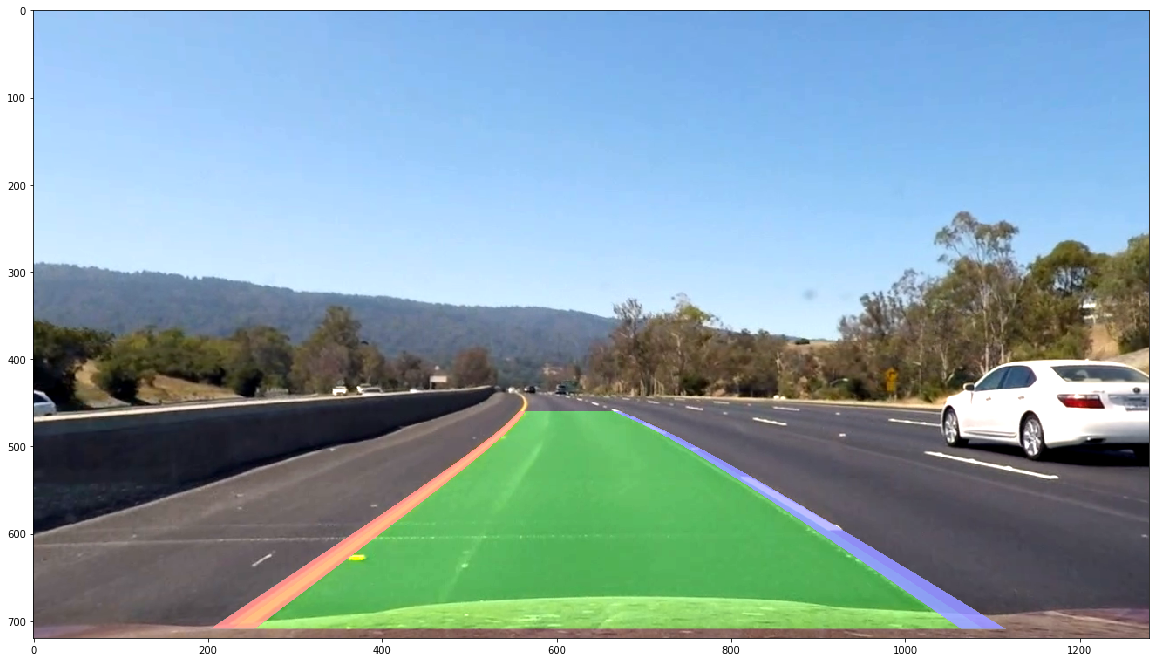

In [7]:
line_lt, line_rt = Line(buffer_len=10), Line(buffer_len=10)
ret, mtx, dist, rvecs, tvecs = calibration(cal_chessboard_dir='camera_cal')
img = mpimg.imread('singleshot/test.jpg')
img_undistorted = undistort(img, mtx, dist, verbose=False)
img_binary = binarize(img_undistorted, verbose=False)
img_birdeye, M, Minv = birdeye(img_binary, verbose=False)
line_lt, line_rt, img_out = get_fits_by_sliding_windows(img_birdeye, line_lt, line_rt, n_windows=7, verbose=True)

# show result
blend_onto_road = draw_back_onto_the_road(img_undistorted, Minv, line_lt, line_rt, False)
plt.figure()
plt.imshow(blend_onto_road)